## 示例：使用 K-近邻算法改进约会网站的配对效果

【用户需求】：海伦一直使用在线约会网站寻找适合自己的约会对象。尽管约会对象会推荐不同的人选，但她并不是喜欢每一个人。经过一番总结，她发现曾交往过三种类型的人。
- 不喜欢的人
- 魅力一般的人
- 极具魅力的人

尽管发现了上述规律，但海伦依然无法将约会网站推荐的匹配对象归入恰当的类别。她觉得可以在周一到周五约会那些魅力一般的人，而周末则更喜欢与那些极具魅力的人为伴。海伦希望我们的分类软件可以更好地帮助她将匹配对象划分到确切的分类中。此外，海伦还收集了一些约会网站未曾记录的数据信息，她认为这些数据更有助于匹配对象的归类。

In [32]:
# 导入所需的包
from pandas import read_csv
import numpy as np
import operator

# 导入 KNN 实现
def classify(inX, dataset, labels, k):
    dataset_size = dataset.shape[0]
    diff_mat = np.tile(inX, (dataset_size, 1)) - dataset
    sq_diff_mat = diff_mat**2
    sq_distance = sq_diff_mat.sum(axis=1)
    distances = sq_distance**0.5
    sorted_dist_indicies = distances.argsort()
    class_count = {}
    for i in range(k):
        vote_label = labels[sorted_dist_indicies[i]]
        class_count[vote_label] = class_count.get(vote_label, 0) + 1
    sorted_class_count = sorted(class_count.items(), key=operator.itemgetter(1), reverse=True)
    return sorted_class_count[0][0]

In [3]:
# 查看数据
dataset = read_csv('./datingTestSet2.txt', delimiter='\t', names=['每年获得的飞行常客里程数', '玩视频游戏所耗时间百分比', '每周消费的冰淇淋公升数', '类型'])
dataset.head(10)

,每年获得的飞行常客里程数,玩视频游戏所耗时间百分比,每周消费的冰淇淋公升数,类型
0,40920,8.326976,0.953952,3
1,14488,7.153469,1.673904,2
2,26052,1.441871,0.805124,1
3,75136,13.147394,0.428964,1
4,38344,1.669788,0.134296,1
5,72993,10.141740,1.032955,1
6,35948,6.830792,1.213192,3
7,42666,13.276369,0.543880,3
8,67497,8.631577,0.749278,1
9,35483,12.273169,1.508053,3


### 准备数据：从文本文件中解析数据
海伦收集约会数据已经有了一段时间，她把这些数据存放在文本文件 datingTestSet2.txt 中，每个样本数据占据一行，总共有 1000 行。海伦的样本主要包含以下 3 种特征：
- 每年获得的飞行常客里程数。
- 玩视频游戏所耗时间百分比。
- 每周消费的冰淇淋公升数。

在将上述数据输入到分类器之前，必须将待处理数据的格式改变为分类器可以接受的格式。

In [4]:
def file2matrix(filename):
    fr = open(filename)
    # 读取数据
    array_of_lines = fr.readlines()
    # 获取数据的数目
    number_of_lines = len(array_of_lines)
    # 初始化数据集和对应的标签向量
    return_mat = np.zeros((number_of_lines, 3))
    class_label_vector = []
    index = 0
    # 循环读取数据集和标签内容
    for line in array_of_lines:
        line = line.strip()
        list_from_line = line.split('\t')
        # 读取数据集
        return_mat[index, :] = list_from_line[0:3]
        # 读取标签内容
        class_label_vector.append(int(list_from_line[-1]))
        index += 1
    fr.close()
    return return_mat, class_label_vector

创建名为 file2matrix 的函数，以此来处理输入格式问题。
- 输入：文件名字符串；
- 输出：训练样本矩阵和类标签向量。

In [5]:
dating_data_mat, dating_labels = file2matrix('datingTestSet2.txt')

In [6]:
dating_data_mat

array([[4.0920000e+04, 8.3269760e+00, 9.5395200e-01],
       [1.4488000e+04, 7.1534690e+00, 1.6739040e+00],
       [2.6052000e+04, 1.4418710e+00, 8.0512400e-01],
       ...,
       [2.6575000e+04, 1.0650102e+01, 8.6662700e-01],
       [4.8111000e+04, 9.1345280e+00, 7.2804500e-01],
       [4.3757000e+04, 7.8826010e+00, 1.3324460e+00]])

In [7]:
dating_labels[0:20]

[3, 2, 1, 1, 1, 1, 3, 3, 1, 3, 1, 1, 2, 1, 1, 1, 1, 1, 2, 3]

现在已经从文本文件中导入了数据，并将其格式化为想要的格式，接着我们需要了解数据的真实含义。直接浏览文本文件，这种方式非常不友好，一般来说，我们会采用图形化的方式直观地展示数据。

### 分析数据：使用 Matplotlib 创建散点图

In [8]:
import matplotlib
from matplotlib import pyplot as plt

fig = plt.figure()
ax = fig.add_subplot(111)
ax.scatter(dating_data_mat[:, 1], dating_data_mat[:, 2])
plt.show()

<Figure size 640x480 with 1 Axes>

散点图使用 dating_data_mat 矩阵的第二、三列数据，分别表示特征值“玩视频游戏所耗时间百分比”和“每周所消费的冰淇淋公升数”。

由于没有使用样本分类的特征值，很难从上图中看到任何有用的数据模式信息。一般来说，我们会采用色彩或其他的记号来标记不同样本分类，以便更好地理解数据信息。Matplotlib库提供的 scatter 函数支持个性化标记散点图上的点。

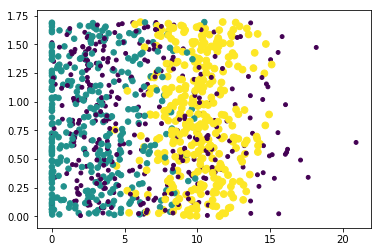

In [9]:
fig = plt.figure()
ax = fig.add_subplot(111)
ax.scatter(dating_data_mat[:, 1], dating_data_mat[:, 2], 15.0 * np.array(dating_labels), 15.0 * np.array(dating_labels))
plt.show()

利用 dating_labels 存储的类标签属性，在散点图上绘制了色彩不等、尺寸不同的点。利用颜色及尺寸标识了数据点的属性类别，因而基本上可以从上图看到数据点所属三个样本分类的区域轮廓。

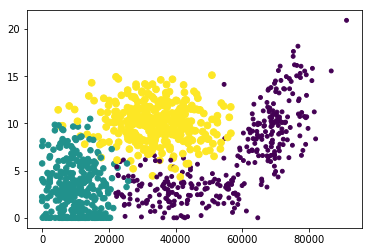

In [10]:
fig = plt.figure()
ax = fig.add_subplot(111)
ax.scatter(dating_data_mat[:, 0], dating_data_mat[:, 1], 15.0 * np.array(dating_labels), 15.0 * np.array(dating_labels))
plt.show()

采用 dating_data_mat 的第一、二列属性可以得到更好地展示效果。图中清晰地标识了三个不同的样本分类区域，具有不同爱好的人其类别区域也不同。

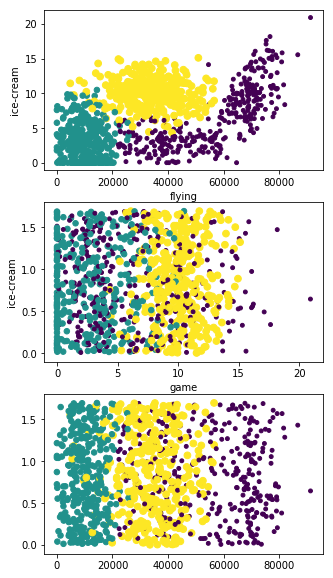

In [11]:
fig = plt.figure(figsize=(5, 10))
ax1 = fig.add_subplot(311)
ax2 = fig.add_subplot(312)
ax3 = fig.add_subplot(313)
ax1.scatter(dating_data_mat[:, 0], dating_data_mat[:, 1], 15.0 * np.array(dating_labels), 15.0 * np.array(dating_labels))
ax1.set_xlabel('flying')
ax1.set_ylabel('game')
ax2.scatter(dating_data_mat[:, 1], dating_data_mat[:, 2], 15.0 * np.array(dating_labels), 15.0 * np.array(dating_labels))
ax2.set_xlabel('game')
ax2.set_ylabel('ice-cream')
ax3.scatter(dating_data_mat[:, 0], dating_data_mat[:, 2], 15.0 * np.array(dating_labels), 15.0 * np.array(dating_labels))
ax1.set_xlabel('flying')
ax1.set_ylabel('ice-cream')
plt.show()

当然，我们也可以把所有的特征属性两两组合来查看分类情况。

### 准备数据：归一化数值
$$\sqrt{(40920 - 14488)^2 + (8.32 - 7.15)^2 + (0.95 - 1.67)^2}$$

从上述方程式中可以发现，数字差值最大的属性对计算结果的影响最大，也就是说，每年获取的飞行常客里程数对于计算结果的影响将远远大于其他两个特征属性。而产生这种现象的唯一原因，仅仅是因为飞行常客里程数远大于其他特征值。但海伦认为这三种特征是同等重要的，因此作为三个等权重的特征之一，飞行常客里程数并不应该如此严重地影响到计算结果。

In [12]:
dataset.head()

,每年获得的飞行常客里程数,玩视频游戏所耗时间百分比,每周消费的冰淇淋公升数,类型
0,40920,8.326976,0.953952,3
1,14488,7.153469,1.673904,2
2,26052,1.441871,0.805124,1
3,75136,13.147394,0.428964,1
4,38344,1.669788,0.134296,1


在处理这种不同取值范围的特征值时，我们通常采用的方法是将数值归一化，如将取值范围处理为 0 到 1 或者 -1 到 1 之间。下面的公式可以将任意取值范围的特征值转化为 0 到 1 区间内的值。

$$ newValue = \frac{(oldValue - min)}{(max - min)} $$

其中 min 和 max 分别是数据集中的最小特征值和最大特征值。虽然改变数值取值范围增加了分类器的复杂度，但为了得到准确结果，我们必须这么做。

In [13]:
def auto_norm(dataset):
    min_vals = dataset.min(0)
    max_vals = dataset.max(0)
    ranges = max_vals - min_vals
    norm_dataset = np.zeros(np.shape(dataset))
    m = dataset.shape[0]
    norm_dataset = dataset - np.tile(min_vals, (m, 1))
    norm_dataset = norm_dataset / np.tile(ranges, (m, 1))
    return norm_dataset, ranges, min_vals

auto_norm() 函数可以自动将数字特征值转化为 0 到 1 区间。

【注意】：特征值矩阵有 1000 x 3 个值，而 min_vals 和 max_vals 的值都为 1 x 3。为了解决这个问题，我们使用 numpy 库中 tile() 函数将变量内容复制成输入矩阵同样大小的矩阵。

In [14]:
norm_mat, ranges, min_vals = auto_norm(dating_data_mat)
norm_mat

array([[0.44832535, 0.39805139, 0.56233353],
       [0.15873259, 0.34195467, 0.98724416],
       [0.28542943, 0.06892523, 0.47449629],
       ...,
       [0.29115949, 0.50910294, 0.51079493],
       [0.52711097, 0.43665451, 0.4290048 ],
       [0.47940793, 0.3768091 , 0.78571804]])

In [15]:
ranges

array([9.1273000e+04, 2.0919349e+01, 1.6943610e+00])

In [16]:
min_vals

array([0.      , 0.      , 0.001156])

### 测试算法：作为完整程序验证分类器

In [17]:
def dating_class_test():
    ho_ratio = 0.10
    dating_data_mat, dating_labels = file2matrix('datingTestSet2.txt')
    norm_mat, ranges, min_vals = auto_norm(dating_data_mat)
    m = norm_mat.shape[0]
    num_test_vecs = int(m * ho_ratio)
    error_count = 0.0
    for i in range(num_test_vecs):
        classifier_result = classify(norm_mat[i, :], norm_mat[num_test_vecs:m, :], dating_labels[num_test_vecs:m], 3)
        print('The classifier came back with: %d, the real answer is: %d' % (classifier_result, dating_labels[i]))
        if classifier_result != dating_labels[i]:
            error_count += 1.0
    print('The total error rate is: %f' % (error_count / float(num_test_vecs)))

In [20]:
dating_class_test()

The classifier came back with: 3, the real answer is: 3
The classifier came back with: 2, the real answer is: 2
The classifier came back with: 1, the real answer is: 1
The classifier came back with: 1, the real answer is: 1
The classifier came back with: 1, the real answer is: 1
The classifier came back with: 1, the real answer is: 1
The classifier came back with: 3, the real answer is: 3
The classifier came back with: 3, the real answer is: 3
The classifier came back with: 1, the real answer is: 1
The classifier came back with: 3, the real answer is: 3
The classifier came back with: 1, the real answer is: 1
The classifier came back with: 1, the real answer is: 1
The classifier came back with: 2, the real answer is: 2
The classifier came back with: 1, the real answer is: 1
The classifier came back with: 1, the real answer is: 1
The classifier came back with: 1, the real answer is: 1
The classifier came back with: 1, the real answer is: 1
The classifier came back with: 1, the real answe

### 使用算法：构建完整可用系统
上面已经在数据上对分类器进行了测试，现在终于可以使用这个分类器为海伦来对人们分类。我们会给海伦一小段程序，通过该程序海伦会在约会网站上找到某个人并输入他的信息。程序会给出她对对方喜欢程度的预测值。

In [22]:
def classify_person():
    result_list = ['not at all', 'in small doses', 'in large doses']
    percent_tats = float(input('percentage of time spent playing video games?'))
    ff_miles = float(input('frequent flier miles earned per year?'))
    ice_cream = float(input('liters of ice cream consumed per year?'))
    dating_data_mat, dating_labels = file2matrix('datingTestSet2.txt')
    norm_mat, ranges, min_vals = auto_norm(dating_data_mat)
    in_arr = np.array([ff_miles, percent_tats, ice_cream])
    classifier_result = classify((in_arr - min_vals) / ranges, norm_mat, dating_labels, 3)
    print('You will probably like this person:', result_list[classifier_result - 1])

In [23]:
classify_person()

percentage of time spent playing video games?10
frequent flier miles earned per year?10000
liters of ice cream consumed per year?.5
You will probably like this person: in small doses
